In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1)

c:\Users\Marcos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


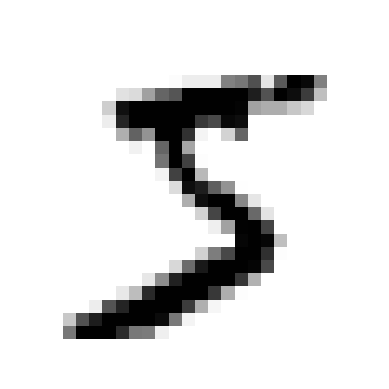

5


In [4]:
X = np.array(X)
some_digit = X[0]

y = y.astype(np.uint8)

some_digit_img = some_digit.reshape((28,28))

plt.imshow(some_digit_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print(y[0])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd.predict([some_digit])

array([ True])

Implementing cross-validation out of the box

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for i_train, i_test in skfolds.split(X_train, y_train_5):
    clone_sgd = clone(sgd)
    
    X_train_folds = X_train[i_train]
    y_train_folds = y_train_5[i_train]
    X_test_fold = X_train[i_test]
    y_test_fold = y_train_5[i_test]

    clone_sgd.fit(X_train_folds, y_train_folds)

    y_pred = clone_sgd.predict(X_test_fold)

    n_correct = sum(y_pred == y_test_fold)

    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [14]:
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [17]:
y_train_predict = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [18]:
confusion = confusion_matrix(y_train_5, y_train_predict)
confusion

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
TP = confusion[1,1]
FP = confusion[0,1]
FN = confusion[1,0]

In [20]:
precision = TP/(TP + FP)
precision

0.8370879772350012

In [21]:
recall = TP/(TP + FN)
recall

0.6511713705958311

In [22]:
precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

In [24]:
f1_score(y_train_5, y_train_predict)

0.7325171197343846

In [25]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

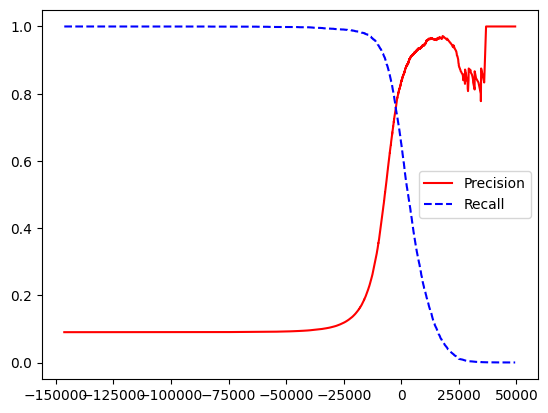

In [27]:
plt.plot(thresholds, precision[:-1], 'r', label='Precision')
plt.plot(thresholds, recall[:-1], 'b--', label='Recall')
plt.legend()
plt.show()

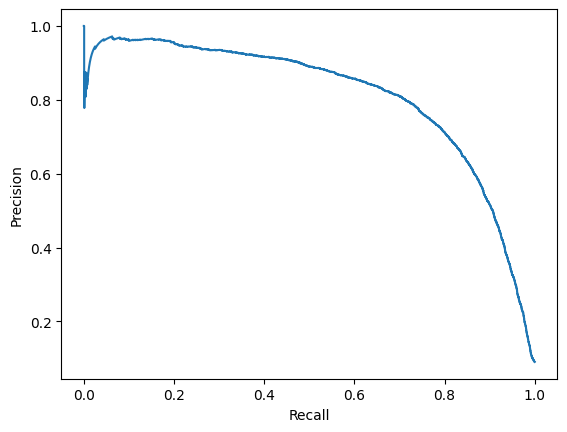

In [28]:
plt.plot(recall[:-1], precision[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [29]:
y_train_prec_90 = thresholds[np.argmax(precision >= 0.90)]
y_train_prec_90

3370.0194991439557

In [30]:
y_train_pred_90 = y_scores >= y_train_prec_90
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

ROC Curve

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

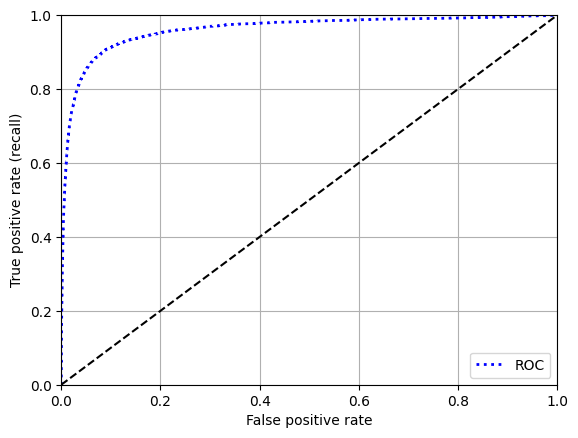

In [34]:
def plot_roc_curve(fpr, tpr, label=None, tc=None):
    plt.plot(fpr, tpr, tc, lw=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate (recall)')
    plt.grid(True)
    if label != None:
        plt.legend()

plot_roc_curve(fpr, tpr, 'ROC', 'b:')
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
forest = RandomForestClassifier(random_state=42)

In [37]:
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method='predict_proba')

In [38]:
y_probas_forest[:,1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [39]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

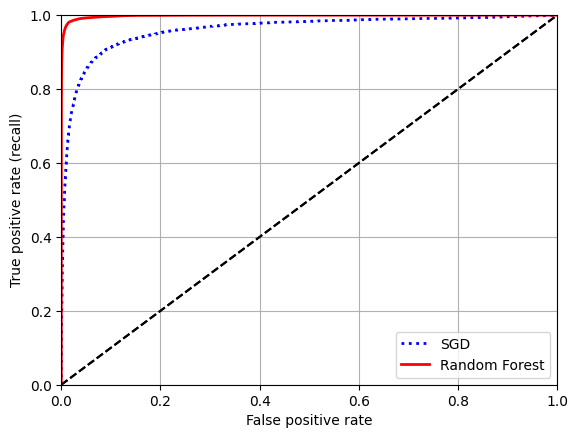

In [40]:
plot_roc_curve(fpr, tpr, 'SGD', 'b:')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest', 'r-')
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [42]:
precision_score(y_train_5, y_scores_forest>0.5)

0.9905083315756169

In [43]:
recall_score(y_train_5, y_scores_forest>0.5)

0.8662608374838591

In [44]:
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [45]:
some_digit = X_train[11]
y_train[11]

5

In [46]:
sgd.predict([some_digit])

array([5], dtype=uint8)

In [47]:
sgd.decision_function([some_digit])

array([[-30446.28807622, -20771.5971377 ,  -4069.97324426,
         -7297.18084344,  -2335.35560779,   3839.63697115,
        -27845.48223256, -11660.53889926,   -540.54962964,
        -11918.2854924 ]])

In [48]:
ovo = OneVsOneClassifier(SGDClassifier(random_state=42))

In [49]:
ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [50]:
ovo.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovo.estimators_)

45

In [52]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
forest.predict([some_digit])

array([5], dtype=uint8)

In [54]:
forest.predict([X_train[0]])

array([5], dtype=uint8)

In [55]:
forest.predict_proba([some_digit])

array([[0.01, 0.05, 0.02, 0.  , 0.  , 0.9 , 0.  , 0.  , 0.01, 0.01]])

In [56]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [ ]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]],
      dtype=int64)

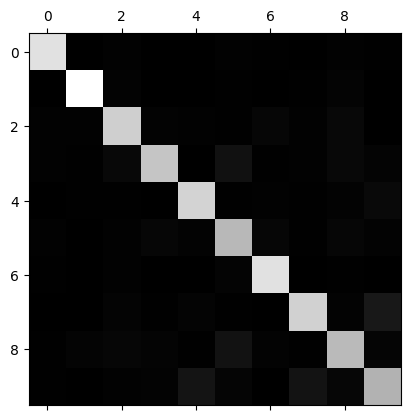

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
norm_conf_mx.shape

(10, 10)

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

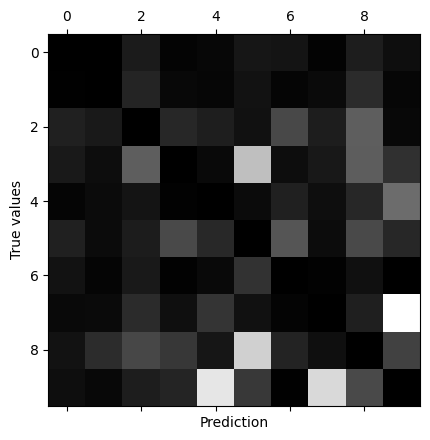

In [ ]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel('Prediction')
plt.ylabel('True values')
plt.show()

In [16]:
y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

In [23]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [27]:
i = 55
some_digit = X_train[i]
y_train[i]

8

In [28]:
kn.predict([some_digit])

array([[ True, False]])

In [29]:
y_train_kn_pred = cross_val_predict(kn, X_train, y_multilabel, cv=3)

In [32]:
f1_score(y_multilabel, y_train_kn_pred, average='macro')

0.976410265560605

In [33]:
f1_score(y_multilabel, y_train_kn_pred, average='weighted')

0.9778357403921755

In [44]:
dig_5 = X_train[0]
n = int(np.sqrt(len(dig_5)))
dig_5 = np.reshape(dig_5, (n,n))

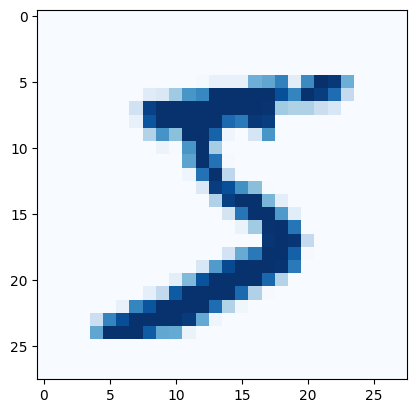

In [53]:
plt.imshow(dig_5, cmap=plt.cm.Blues)
plt.show()

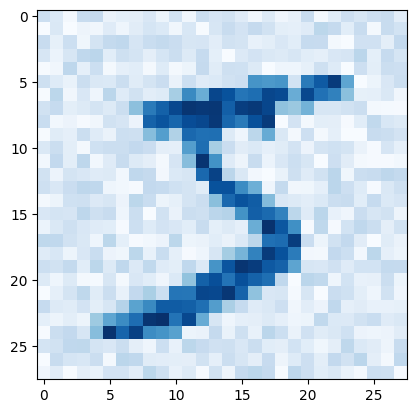

In [57]:
noise_5 = np.random.randint(0, 100, (n,n))
plt.imshow(dig_5 + noise_5, cmap=plt.cm.Blues)
plt.show()

In [79]:
m,n = X_train.shape
noise = np.random.randint(0, 100, (m,n))
X_train_mod = X_train + noise

In [80]:
m,n = X_test.shape
noise = np.random.randint(0, 100, (m,n))
X_test_mod = X_test + noise

In [81]:
y_train_mod = X_train
y_test_mod = X_test

In [82]:
kn.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [86]:
clean_digit = kn.predict([X_test_mod[i]])

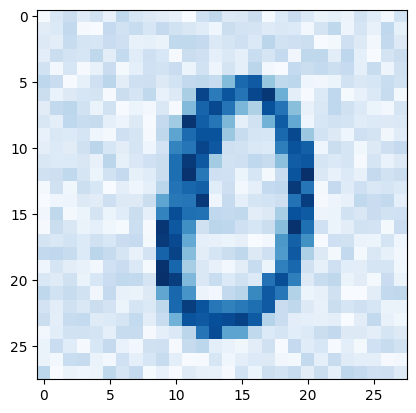

In [89]:
plt.imshow(np.reshape(X_test_mod[i], (28,28)), cmap=plt.cm.Blues)

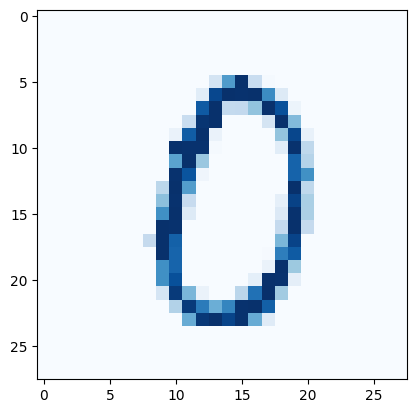

In [88]:
plt.imshow(np.reshape(clean_digit, (28,28)), cmap=plt.cm.Blues)